## 作業
在鐵達尼資料集中，可以用今天範例中提到的三種辨識異常值的方法，以 training data 為資料集。  
1.觀察票價是否有異常值的現象?  
2.你覺得找出的異常是真的異常? 你覺得需要做處理嗎?  
(試著講出自己的想法。)  

### 資料
鐵達尼號 train 資料集


In [1]:
# library
import numpy as np
import pandas as pd
import seaborn  as sns
from scipy import stats
import math
import statistics
import matplotlib.pyplot as plt
#讓圖可以在 jupyter notebook顯示
%matplotlib inline

In [2]:
df_train = pd.read_csv( 'Titanic_train.csv' )
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### 探索性分析:
*  觀察-是否有異常值  
我們來觀察一下 Fare 變數吧!!

In [3]:
# 檢查訓練資料集的 Fare 欄位中是否有遺失值 ?
def Missing_Counts( Data ) : 
    missing = Data.isnull().sum()  
    missing = missing[ missing>0 ]
    missing.sort_values( inplace=True ) 
    
    Missing_Count = pd.DataFrame( { 'ColumnName':missing.index, 'MissingCount':missing.values } ) 
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['MissingCount'].apply( lambda x:round(x/Data.shape[0]*100,2) )
    return  Missing_Count

Missing_Counts(df_train)

,ColumnName,MissingCount,Percentage(%)
0,Embarked,2,0.22
1,Age,177,19.87
2,Cabin,687,77.10


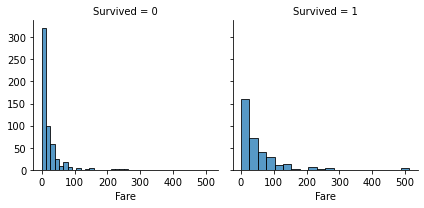

In [4]:
g = sns.FacetGrid( df_train, col='Survived' )
g.map( sns.histplot, 'Fare', bins=20 )
plt.show()

## Q1:觀察票價是否有異常值的現象?

## 方法1
* 進行一個描述性的統計（規定範圍），從而檢視哪些值是不合理的（範圍以外的值）。  


In [5]:
df_train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

## 方法 2
* 進行 3 倍標準差原則的計算，從而檢視哪些值是可疑的異常值。  

In [6]:
# 創建一個函數，尋找在資料中超出設定倍數的標準差的異常值。
# ys: 資料、threshold: 設定幾倍標準差
def outliers_z_score( ys, threshold ):
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores)>threshold)

In [7]:
outlier_index = outliers_z_score( df_train['Fare'], 3 )
outlier_index

(array([ 27,  88, 118, 258, 299, 311, 341, 377, 380, 438, 527, 557, 679,
        689, 700, 716, 730, 737, 742, 779], dtype=int64),)

In [8]:
print( "'Fare' 欄位中疑似的異常值: " )
df_train.loc[ outlier_index[0], 'Fare' ]

'Fare' 欄位中疑似的異常值: 


27     263.0000
88     263.0000
118    247.5208
258    512.3292
299    247.5208
311    262.3750
341    263.0000
377    211.5000
380    227.5250
438    263.0000
527    221.7792
557    227.5250
679    512.3292
689    211.3375
700    227.5250
716    227.5250
730    211.3375
737    512.3292
742    262.3750
779    211.3375
Name: Fare, dtype: float64

## 方法 3 - 盒鬚圖判別法(IQR method)

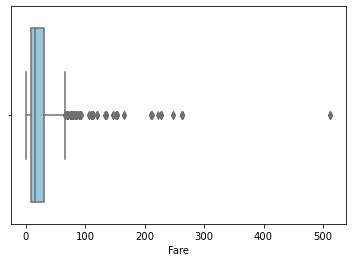

In [9]:
sns.boxplot( x=df_train['Fare'], whis=1.5, orient='h', color='skyblue' )
plt.xlabel( 'Fare' )
plt.show()

In [10]:
def outliers_iqr( ys, times ):
    # 注意: 使用 np.percentile 要去除 nan ，不然計算出來會錯誤!
    # quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    quartile_1, quartile_3 = np.nanpercentile( ys, [25,75] )
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * times)
    upper_bound = quartile_3 + (iqr * times)
    return np.where( (ys > upper_bound) | (ys < lower_bound) )

In [11]:
outliers_index2 = outliers_iqr( df_train['Fare'], 1.5 )
outliers_index2

(array([  1,  27,  31,  34,  52,  61,  62,  72,  88, 102, 118, 120, 124,
        139, 151, 159, 180, 195, 201, 215, 218, 224, 230, 245, 256, 257,
        258, 262, 268, 269, 275, 290, 291, 297, 299, 305, 306, 307, 310,
        311, 318, 319, 324, 325, 332, 334, 336, 337, 341, 366, 369, 373,
        375, 377, 380, 385, 390, 393, 412, 435, 438, 445, 453, 484, 486,
        496, 498, 504, 505, 520, 527, 537, 540, 544, 550, 557, 558, 581,
        585, 587, 591, 609, 627, 641, 645, 655, 659, 660, 665, 679, 681,
        689, 698, 700, 708, 716, 730, 737, 741, 742, 745, 759, 763, 765,
        779, 789, 792, 802, 820, 829, 835, 846, 849, 856, 863, 879],
       dtype=int64),)

In [12]:
print( "'Fare' 欄位中疑似的異常值(超出 1.5 倍 IQR): " )
df_train.loc[ outliers_index2[0], 'Fare' ]

'Fare' 欄位中疑似的異常值(超出 1.5 倍 IQR): 


1       71.2833
27     263.0000
31     146.5208
34      82.1708
52      76.7292
         ...   
846     69.5500
849     89.1042
856    164.8667
863     69.5500
879     83.1583
Name: Fare, Length: 116, dtype: float64

## Q2: 你覺得找出的異常是真的異常? 你覺得需要做處理嗎?

## Ans:  無法僅憑單一欄位的分析來判斷是否有異常值，可藉由與其他欄位的關聯性，獲取更多資訊再決定是否為異常，及是否該處理。